In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm
from sklearn.utils import resample
from collections import defaultdict

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
%config InlineBackend.figure_formats = ['svg']

project_dir = os.path.expanduser('~/RL_2024/')

In [3]:
γ = 1.0  # discount factor for evaluation

nS = 750
nA = 25

nS_term = 2
S_survival = 750
S_death = 751

nS_total = nS + nS_term

## Load Everything

In [4]:
with open(project_dir + 'data/env_model/gymP_orig.pkl', 'rb') as f:
    gymP_orig = pickle.load(f)
with open(project_dir + 'data/env_model/gymP_dropped.pkl', 'rb') as f:
    gymP_dropped = pickle.load(f)
with open(project_dir + 'data/env_model/gymP_shifted.pkl', 'rb') as f:
    gymP_shifted = pickle.load(f)

π_b_orig = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_orig.pkl').values
π_b_dropped = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_dropped.pkl').values
π_b_shifted = pd.read_pickle(project_dir + 'data/behavior_policy/π_b_shifted.pkl').values

SA_mask_orig = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_orig.pkl').values
SA_mask_dropped = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_dropped.pkl').values
SA_mask_shifted = pd.read_pickle(project_dir + 'data/behavior_policy/SA_mask_shifted.pkl').values

In [5]:
df_train_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_orig = pd.read_csv(project_dir + 'data/trajectory_data/traj_orig_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

df_train_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_dropped = pd.read_csv(project_dir + 'data/trajectory_data/traj_dropped_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

df_train_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_train.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_val_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_val.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})
df_test_shifted = pd.read_csv(project_dir + 'data/trajectory_data/traj_shifted_test.csv', dtype={"a:action": "Int64", 'a:next_action': "Int64"})

In [6]:
with open(project_dir + 'data/value_funcs/VI_orig__Vs.pkl', 'rb') as f:
    Vs_orig = pickle.load(f)

with open(project_dir + 'data/value_funcs/VI_dropped__Vs.pkl', 'rb') as f:
    Vs_dropped = pickle.load(f)

with open(project_dir + 'data/value_funcs/VI_shifted__Vs.pkl', 'rb') as f:
    Vs_shifted = pickle.load(f)

In [7]:
def V2Q(V, gymP, nS, nA, gamma):
    Q = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            Q[s, a] = sum(p * (r + (0 if done else gamma * V[s_])) for p, s_, r, done in gymP[s][a])
    return Q  # save full Q-value matrix

In [8]:
gymP = gymP_orig
π_b = π_b_orig
SA_mask = SA_mask_orig
df_train = df_train_orig
df_val = df_val_orig
df_test = df_test_orig
Vs = Vs_orig

# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

π_star_orig = π_star

In [9]:
gymP = gymP_dropped
π_b = π_b_dropped
SA_mask = SA_mask_dropped
df_train = df_train_dropped
df_val = df_val_dropped
df_test = df_test_dropped
Vs = Vs_dropped

# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

π_star_dropped = π_star

In [10]:
gymP = gymP_shifted
π_b = π_b_shifted
SA_mask = SA_mask_shifted
df_train = df_train_shifted
df_val = df_val_shifted
df_test = df_test_shifted
Vs = Vs_shifted

# value functions from value iteration - same discount for policy learning
V_opt = Vs[-1]
Q_opt = V2Q(V_opt, gymP, nS, nA, gamma=0.99)

# mask out rare actions for constructing policy
Q_opt_masked = Q_opt.copy()
Q_opt_masked[~SA_mask] = np.nan

# policy from value iteration with tie-breaking
π_star = np.zeros((nS, nA))
for s in range(nS):
    Q_s = Q_opt_masked[s, :]
    max_val = np.nanmax(Q_s)
    best_actions = np.where(Q_s == max_val)[0]
    π_star[s, best_actions] = 1 / len(best_actions)

π_star_shifted = π_star

## Compare (dropped vs shifted)

In [11]:
π_star_dropped

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
π_star_shifted

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
π_compare = (π_star_dropped != π_star_shifted).any(axis=1)

In [14]:
π_compare.mean()

np.float64(0.44666666666666666)

In [15]:
s_different = []
for s in range(nS):
    if any(π_star_dropped[s, :] != π_star_shifted[s, :]):
        s_different.append(s)


In [16]:
A_by_A = np.zeros((nA, nA))  # dropped by shifted
A_by_A_state_dict = defaultdict(list)
for s in range(nS):
    a_i = np.where(π_star_dropped[s,:] != 0)[0]
    a_j = np.where(π_star_shifted[s,:] != 0)[0]
    A_by_A[a_i, a_j] += 1

    for a_i_ in a_i:
        for a_j_ in a_j:
            A_by_A_state_dict[a_i_, a_j_].append(s)

A_by_A[A_by_A == 0] = np.nan

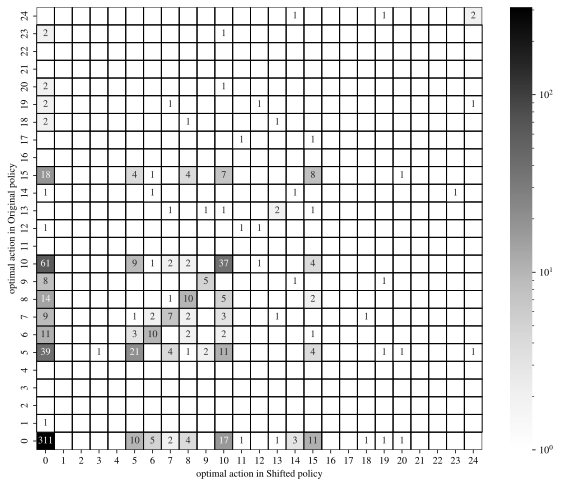

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    A_by_A, annot=True, fmt='.0f', cmap='Grays', norm=matplotlib.colors.LogNorm(),
    linecolor='black', linewidths=1, ax=ax)
ax.invert_yaxis()
plt.xlabel('optimal action in Shifted policy')
plt.ylabel('optimal action in Original policy')
# plt.title('Action by action comparison of policies')
plt.savefig(project_dir + 'figures/mimic_policy_comparison.pdf', bbox_inches='tight')
plt.show()

In [18]:
df_test_in = pd.read_csv(project_dir + 'data/traj_data_test.csv').drop(columns=['m:icustayid', 'a:vaso', 'a:iv'])
full_zs = pd.read_csv(project_dir + 'dataset/sepsis_final_data_RAW_withTimes_newActions.csv')
acuity_scores = pd.read_csv(project_dir + 'dataset/acuity_scores.csv')
df_full_with_acuity = pd.merge(df_test_in, acuity_scores, on=['traj', 'step'], how='left')

In [19]:
df_full_with_acuity = pd.merge(df_full_with_acuity, full_zs, on=['traj', 'step'], how='left')

In [20]:
df_full_with_acuity.columns

Index(['traj', 'step', 'r:reward_x', 'a:action_x', 's:state', 'c:SOFA',
       'c:OASIS', 'c:SAPSii', 'm:presumed_onset', 'm:charttime', 'm:icustayid',
       'o:gender', 'o:mechvent', 'o:re_admission', 'o:age', 'o:Weight_kg',
       'o:GCS', 'o:HR', 'o:SysBP', 'o:MeanBP', 'o:DiaBP', 'o:RR', 'o:Temp_C',
       'o:FiO2_1', 'o:Potassium', 'o:Sodium', 'o:Chloride', 'o:Glucose',
       'o:Magnesium', 'o:Calcium', 'o:Hb', 'o:WBC_count', 'o:Platelets_count',
       'o:PTT', 'o:PT', 'o:Arterial_pH', 'o:paO2', 'o:paCO2', 'o:Arterial_BE',
       'o:HCO3', 'o:Arterial_lactate', 'o:SOFA', 'o:SIRS', 'o:Shock_Index',
       'o:PaO2_FiO2', 'o:cumulated_balance', 'o:SpO2', 'o:BUN', 'o:Creatinine',
       'o:SGOT', 'o:SGPT', 'o:Total_bili', 'o:INR', 'o:input_total',
       'o:output_total', 'o:output_4hourly', 'r:reward_y', 'o:max_dose_vaso',
       'o:input_4hourly', 'a:vaso', 'a:iv_OLD', 'a:iv', 'a:action_OLD',
       'a:action_y'],
      dtype='object')

In [21]:
s_shifted_zero_dropped_zero = A_by_A_state_dict[0, 0]
s_shifted_zero_dropped_nonzero = sum([A_by_A_state_dict[a_, 0] for a_ in range(nA) if a_ != 0], [])
s_dropped_zero_shifted_nonzero = sum([A_by_A_state_dict[0, a_] for a_ in range(nA) if a_ != 0], [])
s_dropped_nonzero_shifted_nonzero = sum([A_by_A_state_dict[a__, a_] for a_ in range(nA) if a_ != 0 for a__ in range(nA) if a__ != 0 ], [])

In [24]:
len(sum([A_by_A_state_dict[a__, a_] for a_ in range(nA) for a__ in range(nA) if a__ != a_], []))

336

In [21]:
len(s_shifted_zero_dropped_zero), len(s_shifted_zero_dropped_nonzero), len(s_dropped_zero_shifted_nonzero), len(s_dropped_nonzero_shifted_nonzero)

(311, 171, 57, 212)

In [22]:
df__tmp00 = df_full_with_acuity[df_full_with_acuity['s:state'].isin(s_shifted_zero_dropped_zero)]
df__tmp01 = df_full_with_acuity[df_full_with_acuity['s:state'].isin(s_dropped_zero_shifted_nonzero)]
df__tmp10 = df_full_with_acuity[df_full_with_acuity['s:state'].isin(s_shifted_zero_dropped_nonzero)]
df__tmp11 = df_full_with_acuity[df_full_with_acuity['s:state'].isin(s_dropped_nonzero_shifted_nonzero)]

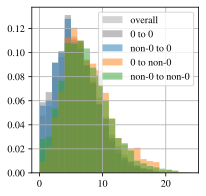

In [23]:
fig, ax = plt.subplots(figsize=(3,3))
acuity_scores['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), color='darkgray', ax=ax, label='overall')
df__tmp00['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), ax=ax, color='gray', label='0 to 0')
df__tmp10['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), ax=ax, label='non-0 to 0')
df__tmp01['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), ax=ax, label='0 to non-0')
df__tmp11['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), ax=ax, label='non-0 to non-0')
plt.legend()
plt.show()

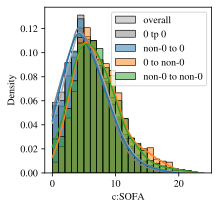

In [24]:
fig, ax = plt.subplots(figsize=(3,3))
sns.histplot(acuity_scores['c:SOFA'], binwidth=1, stat="density", kde=True, kde_kws=dict(bw_adjust=2), alpha=0.5, color='darkgray', ax=ax, label='overall')
sns.histplot(df__tmp00['c:SOFA'], binwidth=1, stat="density", kde=True, kde_kws=dict(bw_adjust=1.5), alpha=0.5, color='gray', ax=ax, label='0 tp 0')
sns.histplot(df__tmp10['c:SOFA'], binwidth=1, stat="density", kde=True, kde_kws=dict(bw_adjust=1.5), alpha=0.5, ax=ax, label='non-0 to 0')
sns.histplot(df__tmp01['c:SOFA'], binwidth=1, stat="density", kde=True, kde_kws=dict(bw_adjust=1.5), alpha=0.5, ax=ax, label='0 to non-0')
sns.histplot(df__tmp11['c:SOFA'], binwidth=1, stat="density", kde=True, kde_kws=dict(bw_adjust=1.5), alpha=0.5, ax=ax, label='non-0 to non-0')
plt.legend()
plt.show()

In [25]:
colors = [
    "darkorange",  # 'orig 0 to shifted 0'
    "#d73027",  # 'orig non-0 to shifted 0'
    "deeppink",  # 'orig 0 to shifted non-0'
    "purple",  # 'orig non-0 to shifted non-0'
]


In [26]:
matplotlib.colors.to_hex(colors[0]), matplotlib.colors.to_hex(colors[1]), matplotlib.colors.to_hex(colors[2]), matplotlib.colors.to_hex(colors[3])

('#ff8c00', '#d73027', '#ff1493', '#800080')

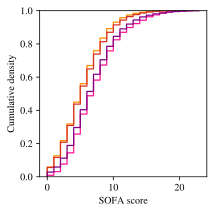

In [27]:
col_to_plot = 'c:SOFA'

fig, ax = plt.subplots(figsize=(3,3))
# sns.ecdfplot(acuity_scores[col_to_plot], lw=1, ls='--', color='darkgray', ax=ax, label='overall')
sns.ecdfplot(df__tmp00[col_to_plot], lw=1.25, color=colors[0], ax=ax, label='orig 0 to shifted 0')
sns.ecdfplot(df__tmp10[col_to_plot], lw=1.25, color=colors[1], ax=ax, label='orig non-0 to shifted 0')
sns.ecdfplot(df__tmp01[col_to_plot], lw=1.25, color=colors[2], ax=ax, label='orig 0 to shifted non-0')
sns.ecdfplot(df__tmp11[col_to_plot], lw=1.25, color=colors[3], ax=ax, label='orig non-0 to shifted non-0')
plt.xlabel('SOFA score')
plt.ylabel('Cumulative density')
# plt.legend()
plt.savefig(project_dir + 'figures/mimic_policy_comparison_sofa.pdf', bbox_inches='tight')
plt.show()

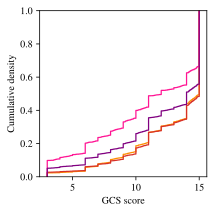

In [28]:
col_to_plot = 'o:GCS'

fig, ax = plt.subplots(figsize=(3,3))
# sns.ecdfplot(df_full_with_acuity[col_to_plot], lw=1, ls='--', color='darkgray', ax=ax, label='overall')
sns.ecdfplot(df__tmp00[col_to_plot], lw=1.25, color=colors[0], ax=ax, label='0 to 0')
sns.ecdfplot(df__tmp10[col_to_plot], lw=1.25, color=colors[1], ax=ax, label='non-0 to 0')
sns.ecdfplot(df__tmp01[col_to_plot], lw=1.25, color=colors[2], ax=ax, label='0 to non-0')
sns.ecdfplot(df__tmp11[col_to_plot], lw=1.25, color=colors[3], ax=ax, label='non-0 to non-0')
plt.xlabel('GCS score')
plt.ylabel('Cumulative density')
# plt.legend()
plt.savefig(project_dir + 'figures/mimic_policy_comparison_gcs.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# pink "orig 0 to shifted non-0" - significantly sicker patient states, 
# shifted policy recommends some form of treatments, 
# but orig/dropped policy systematically withholds treatments, which is counterintuitive

# dark red "orig non-0 to shifted 0" - significantly healthier patient states, 
# shifted policy recommends no treatments
# dropped policy is more aggressive, recommends lots of treatments, which is counterintuitive

In [166]:
# df__tmp01['c:SOFA'].describe()
df__tmp01['o:GCS'].describe()

count    2344.000000
mean       10.949239
std         4.211188
min         3.000000
25%         7.930556
50%        12.000000
75%        15.000000
max        15.000000
Name: o:GCS, dtype: float64

In [167]:
df__tmp11['o:GCS'].describe()

count    10341.000000
mean        12.189763
std          3.640279
min          3.000000
25%         10.000000
50%         14.000000
75%         15.000000
max         15.000000
Name: o:GCS, dtype: float64

In [138]:
df_full_with_acuity['c:SOFA'].mean(), df_full_with_acuity['o:GCS'].mean()

(np.float64(5.856148491879351), np.float64(12.624983890145604))

In [158]:
df__tmp00['c:SOFA'].mean(), df__tmp00['o:GCS'].mean()

(np.float64(5.286315051690906), np.float64(12.932267275596653))

In [139]:
df__tmp10['c:SOFA'].mean(), df__tmp10['o:GCS'].mean()

(np.float64(5.48686553873553), np.float64(12.977562653335353))

In [ ]:
df__tmp01['c:SOFA'].mean(), df__tmp01['o:GCS'].mean()

(np.float64(7.236774744027303), np.float64(10.949238977627926))

In [159]:
df__tmp11['c:SOFA'].mean(), df__tmp11['o:GCS'].mean()

(np.float64(6.807465428875351), np.float64(12.189762888708353))

In [ ]:
(
    scipy.stats.mannwhitneyu(df_full_with_acuity['c:SOFA'], df__tmp00['c:SOFA'], alternative='greater'),
    scipy.stats.mannwhitneyu(df_full_with_acuity['c:SOFA'], df__tmp10['c:SOFA'], alternative='greater'),
    scipy.stats.mannwhitneyu(df_full_with_acuity['c:SOFA'], df__tmp01['c:SOFA'], alternative='less'),
    scipy.stats.mannwhitneyu(df_full_with_acuity['c:SOFA'], df__tmp11['c:SOFA'], alternative='less'),
    scipy.stats.mannwhitneyu(df_full_with_acuity['o:GCS'], df__tmp01['o:GCS'], alternative='greater'),
    scipy.stats.mannwhitneyu(df_full_with_acuity['o:GCS'], df__tmp00['o:GCS'], alternative='less'),
    scipy.stats.mannwhitneyu(df_full_with_acuity['o:GCS'], df__tmp10['o:GCS'], alternative='less'),
    scipy.stats.mannwhitneyu(df_full_with_acuity['o:GCS'], df__tmp11['o:GCS'], alternative='greater'),
)

(MannwhitneyuResult(statistic=np.float64(360249635.0), pvalue=np.float64(1.5348847163448162e-58)),
 MannwhitneyuResult(statistic=np.float64(184297245.5), pvalue=np.float64(5.270906854247287e-18)),
 MannwhitneyuResult(statistic=np.float64(36174741.0), pvalue=np.float64(6.60439988172699e-63)),
 MannwhitneyuResult(statistic=np.float64(171610428.5), pvalue=np.float64(3.688140529830142e-114)),
 MannwhitneyuResult(statistic=np.float64(55773255.0), pvalue=np.float64(2.2020662610114286e-85)),
 MannwhitneyuResult(statistic=np.float64(318629026.5), pvalue=np.float64(2.1024272842471409e-16)),
 MannwhitneyuResult(statistic=np.float64(165307606.5), pvalue=np.float64(3.334454651811679e-16)),
 MannwhitneyuResult(statistic=np.float64(212622162.0), pvalue=np.float64(1.1628421766160246e-23)))

In [174]:
(
    scipy.stats.mannwhitneyu(df__tmp01['c:SOFA'], df__tmp11['c:SOFA'], alternative='two-sided'),
    scipy.stats.mannwhitneyu(df__tmp10['c:SOFA'], df__tmp11['c:SOFA'], alternative='two-sided'),
    scipy.stats.mannwhitneyu(df__tmp01['c:SOFA'], df__tmp00['c:SOFA'], alternative='two-sided'),
    scipy.stats.mannwhitneyu(df__tmp10['c:SOFA'], df__tmp00['c:SOFA'], alternative='two-sided'),
)

(MannwhitneyuResult(statistic=np.float64(12829652.0), pvalue=np.float64(8.532501508183142e-06)),
 MannwhitneyuResult(statistic=np.float64(37111823.5), pvalue=np.float64(9.552493753091783e-130)),
 MannwhitneyuResult(statistic=np.float64(25890230.5), pvalue=np.float64(2.7271770686325927e-116)),
 MannwhitneyuResult(statistic=np.float64(78947635.5), pvalue=np.float64(0.00039747421230848794)))

In [175]:
(
    scipy.stats.mannwhitneyu(df__tmp01['o:GCS'], df__tmp11['o:GCS'], alternative='two-sided'),
    scipy.stats.mannwhitneyu(df__tmp10['o:GCS'], df__tmp11['o:GCS'], alternative='two-sided'),
    scipy.stats.mannwhitneyu(df__tmp01['o:GCS'], df__tmp00['o:GCS'], alternative='two-sided'),
    scipy.stats.mannwhitneyu(df__tmp10['o:GCS'], df__tmp00['o:GCS'], alternative='two-sided'),
)

(MannwhitneyuResult(statistic=np.float64(10083669.0), pvalue=np.float64(5.378635229390267e-40)),
 MannwhitneyuResult(statistic=np.float64(51620685.0), pvalue=np.float64(1.6010504067812353e-45)),
 MannwhitneyuResult(statistic=np.float64(14702163.0), pvalue=np.float64(9.41261569717805e-111)),
 MannwhitneyuResult(statistic=np.float64(77763949.5), pvalue=np.float64(0.11163081882215341)))

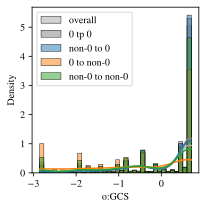

In [ ]:
col_to_plot = 'o:GCS'

fig, ax = plt.subplots(figsize=(3,3))
sns.histplot(df_full_with_acuity[col_to_plot], binwidth=0.1, stat="density", kde=True, kde_kws=dict(bw_adjust=2), alpha=0.5, color='darkgray', ax=ax, label='overall')
sns.histplot(df__tmp00[col_to_plot], binwidth=0.1, stat="density", kde=True, kde_kws=dict(bw_adjust=1.5), alpha=0.5, color='gray', ax=ax, label='0 tp 0')
sns.histplot(df__tmp10[col_to_plot], binwidth=0.1, stat="density", kde=True, kde_kws=dict(bw_adjust=1.5), alpha=0.5, ax=ax, label='non-0 to 0')
sns.histplot(df__tmp01[col_to_plot], binwidth=0.1, stat="density", kde=True, kde_kws=dict(bw_adjust=1.5), alpha=0.5, ax=ax, label='0 to non-0')
sns.histplot(df__tmp11[col_to_plot], binwidth=0.1, stat="density", kde=True, kde_kws=dict(bw_adjust=1.5), alpha=0.5, ax=ax, label='non-0 to non-0')
plt.legend()
plt.show()

In [ ]:
df_full_with_acuity[col_to_plot].describe()

count    38790.000000
mean        -0.002441
std          0.993418
min         -2.855431
25%         -0.484111
50%          0.582983
75%          0.701549
max          0.701549
Name: o:GCS, dtype: float64

In [ ]:
pd.concat([
    acuity_scores['c:SOFA'].describe(), 
    df__tmp00['c:SOFA'].describe(), 
    df__tmp01['c:SOFA'].describe(), 
    df__tmp10['c:SOFA'].describe(), 
], axis=1)

,c:SOFA,c:SOFA,c:SOFA,c:SOFA
count,256573.000000,17121.000000,2344.000000,8984.000000
mean,5.760910,5.286315,7.236775,5.486866
std,3.543473,3.308253,3.838702,3.462405
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,3.000000
50%,5.000000,5.000000,7.000000,5.000000
75%,8.000000,7.000000,9.000000,8.000000
max,24.000000,21.000000,22.000000,20.000000


In [ ]:
df_test_tocheck = df_test_in[df_test_in['s:state'].isin(s_tocheck)]
df_test_tocheck_same = df_test_in[df_test_in['s:state'].isin(s_tocheck_same)]
df_test_tocheck_010 = df_test_in[df_test_in['s:state'].isin(s_tocheck_010)]
df_test_tocheck_100 = df_test_in[df_test_in['s:state'].isin(s_tocheck_100)]

In [ ]:
df_tmp = pd.merge(df_test_tocheck, acuity_scores, on=['traj', 'step'], how='left')
df_tmp2 = pd.merge(df_test_tocheck_same, acuity_scores, on=['traj', 'step'], how='left')
df_tmp3 = pd.merge(df_test_tocheck_010, acuity_scores, on=['traj', 'step'], how='left')
df_tmp4 = pd.merge(df_test_tocheck_100, acuity_scores, on=['traj', 'step'], how='left')

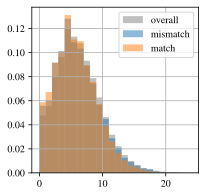

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
acuity_scores['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), color='gray', ax=ax, label='overall')
df_tmp['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), ax=ax, label='mismatch')
df_tmp2['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), ax=ax, label='match')
plt.legend()
plt.show()

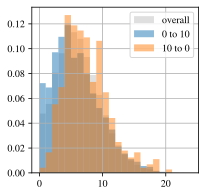

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
acuity_scores['c:SOFA'].hist(alpha=0.25, density=True, bins=np.arange(0,25,1), color='gray', ax=ax, label='overall')
df_tmp3['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), ax=ax, label='0 to 10')
df_tmp4['c:SOFA'].hist(alpha=0.5, density=True, bins=np.arange(0,25,1), ax=ax, label='10 to 0')
plt.legend()
plt.show()

In [ ]:
import scipy

In [ ]:
scipy.stats.mannwhitneyu(df_tmp3['c:SOFA'], df_tmp4['c:SOFA'], alternative='less')

MannwhitneyuResult(statistic=np.float64(784084.0), pvalue=np.float64(3.8554948968302114e-26))